In [1]:
from fastai.text.learner import *
from fastai.basic_data import DataBunch
import torch
from torch import nn
import numpy as np
import pickle
from collections import Counter
import math
%matplotlib inline

In [ ]:
# import os
# os.getcwd()
# os.chdir('drive/My Drive')

## Basic Data setup

In [2]:
# data I/O
data = open('input_bible.txt', 'r').read() # should be simple plain text file
words = Counter(data.split())
words = [k for k in words.keys()]
data_size, vocab_size = len(data), len(words)
word_to_ix  = { ch:i for i,ch in enumerate(words) }
ix_to_word = { i:ch for i,ch in enumerate(words) }

In [3]:
len(words)

31402

In [4]:
#create a data loader
from torch.utils.data import Dataset, DataLoader
#create a custom data dataset / dataloader
class bible_dataset(Dataset):

    def __init__(self, seq_len):
        self.df = open('input_bible.txt', 'r').read().split()
        self.vocab = Counter(self.df)
        self.vocab = [k for k in self.vocab.keys()]
        self.word_to_ix  = {wr:i for i,wr in enumerate(words)}
        self.ix_to_word = {i:wr for i,wr in enumerate(words)}        
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.vocab)

    def __getitem__(self, idx):
        return (np.array([self.word_to_ix[wrd] for wrd in self.df[idx:idx+self.seq_len]]),
                np.array([self.word_to_ix[wrd] for wrd in self.df[idx+1:idx+self.seq_len+1]]))

In [5]:
bible_df = bible_dataset(10)
bible_df[2]

(array([2, 3, 4, 5, 2, 6, 7, 2, 8, 9]),
 array([ 3,  4,  5,  2,  6,  7,  2,  8,  9, 10]))

In [7]:
#define a vanilla rnn 

class vanilla_rnn(nn.Module):
    def __init__(self, input_size, output_size, 
                 hidden_dim, layers):
        super(vanilla_rnn, self).__init__()
        
        self.size = input_size
        self.hidden_dim = hidden_dim
        self.layers = layers
        
        self.rnn = nn.RNN(input_size, hidden_size=hidden_dim, num_layers = layers,
                      batch_first=True)
        #a fully connectd layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    #initialise the hidden states before training
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layers, batch_size, 
                            self.hidden_dim)
        return hidden
    
    #forward pass
    def forward(self, x):
#         print(x)
        batch_size = x.shape[0]
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden
        

In [8]:
seq_len = 10

bible_df = DataLoader(bible_dataset(seq_len), 1)
# bible_df

v_rnn = vanilla_rnn(input_size=vocab_size,
                    output_size=vocab_size,
                    hidden_dim=12,
                    layers=1)
n_epochs = 1
lr=1e-1
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(v_rnn.parameters(), lr=lr)


In [9]:
#one hot encode over the whole vocab

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [10]:
from torch.optim.lr_scheduler import _LRScheduler
class CyclicLR(_LRScheduler):
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    
def cosine(t_max, eta_min=0):  
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler


In [11]:
torch.from_numpy(one_hot_encode(input_seq, vocab_size, 10, 1)).unsqueeze(1).view(-1).long().shape
output1, hidden1 = v_rnn(torch.from_numpy(one_hot_encode(input_seq, vocab_size, 10, 1)))
output1.shape,target_seq.transpose(0,1).long().squeeze(1).shape
# loss_func(input=output, target=target_seq.transpose(0,1).long().squeeze(1))

NameError: name 'input_seq' is not defined

In [12]:
#elements of output are of size = vocab
#there are 10 elements (size of batch/sentence/sequence)
# output[1].size()

In [13]:
# output.size()

In [14]:
# target_seq.size(), output.size()

In [15]:
# target_seq.transpose(0,1).long().squeeze(1).size()

In [237]:
seq_len = 10

bible_df = DataLoader(bible_dataset(seq_len), 1)
# bible_df

v_rnn = vanilla_rnn(input_size=vocab_size,
                    output_size=vocab_size,
                    hidden_dim=12,
                    layers=1)
n_epochs = 1
lr=1e-2
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(v_rnn.parameters(), lr=lr)

iterations_per_epoch = len(bible_df)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

loss_values = []
#training loop
for epoch in range(1,2):
    loss= 0.
    for local_batch in enumerate(bible_df, 0):
        input_seq = local_batch[1][0]
        target_seq = local_batch[1][1]
        optimizer.zero_grad()
        output, hidden = v_rnn(torch.from_numpy(one_hot_encode(input_seq, vocab_size, 10, 1)))
        loss = loss_func(input=output, target=target_seq.transpose(0,1).long().squeeze(1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_values.append(loss.data.item())                        
        if (len(loss_values) % 100 == 0) | (len(loss_values) == 1):
            print(loss.data.item())
            loss_values.append(loss.data.item())

([<matplotlib.lines.Line2D at 0x172e87edf28>], 31720)

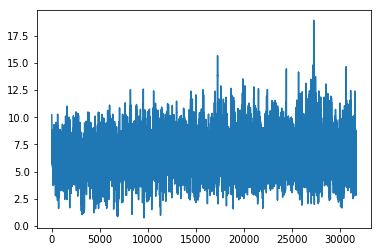

In [38]:
import matplotlib.pyplot as plt
plt.plot(loss_values), len(loss_values)

In [16]:
# torch.save(v_rnn.state_dict(), 'models/v_rnn.pkl')
v_rnn.load_state_dict(torch.load('models/v_rnn.pkl'))

<All keys matched successfully>

## Using Pre trained wikitext 103 model



In [17]:
# from fastai.text.learner import *
# from fastai.datasets import URLs
# from fastai.basic_data import DataBunch

# seq_len = 10
# bible_df = DataLoader(bible_dataset(seq_len), 1)
# language_model_learner(data=DataBunch(bible_df,bible_df,bible_df), arch=AWD_LSTM)

In [18]:
#download the model weights and vocab
# ! wget http://files.fast.ai/models/wt103_tiny.tgz -P "C:\\Git\\karpathy-rnn"
# ! tar xf "C:/Git/karpathy-rnn/models/wt103_tiny.tgz" -C "C:/Git/karpathy-rnn/models"

In [19]:
from fastai.text import *
awd_lstm_model =  get_language_model(arch=AWD_LSTM, vocab_sz=len(bible_df))
old_wgts  = torch.load('models/pretrained/lstm_wt103.pth', map_location='cpu')
old_vocab = pickle.load(open('models/pretrained/itos_wt103.pkl', 'rb'))

In [20]:
old_wgts.keys()

odict_keys(['0.encoder.weight', '0.encoder_dp.emb.weight', '0.rnns.0.weight_hh_l0_raw', '0.rnns.0.module.weight_ih_l0', '0.rnns.0.module.weight_hh_l0', '0.rnns.0.module.bias_ih_l0', '0.rnns.0.module.bias_hh_l0', '0.rnns.1.weight_hh_l0_raw', '0.rnns.1.module.weight_ih_l0', '0.rnns.1.module.weight_hh_l0', '0.rnns.1.module.bias_ih_l0', '0.rnns.1.module.bias_hh_l0', '0.rnns.2.weight_hh_l0_raw', '0.rnns.2.module.weight_ih_l0', '0.rnns.2.module.weight_hh_l0', '0.rnns.2.module.bias_ih_l0', '0.rnns.2.module.bias_hh_l0', '1.decoder.weight', '1.decoder.bias'])

In [21]:
#pre-trained vocab and bible vocab need to be matched up where there's overlap
idx_the_new, idx_the_old = word_to_ix['the'],old_vocab.index('the')

the_wgt  = old_wgts['0.encoder.weight'][idx_the_old]
the_bias = old_wgts['1.decoder.bias'][idx_the_old] 

In [22]:
#match overlap 
def match_embeds(old_wgts, old_vocab, new_vocab):
    wgts = old_wgts['0.encoder.weight']
    bias = old_wgts['1.decoder.bias']
    wgts_m,bias_m = wgts.mean(dim=0),bias.mean()
    new_wgts = wgts.new_zeros(len(word_to_ix), wgts.size(1))
    new_bias = bias.new_zeros(len(word_to_ix))
    otoi = {v:k for k,v in enumerate(old_vocab)}
    for i,w in enumerate(word_to_ix): 
        if w in otoi:
            idx = otoi[w]
            new_wgts[i],new_bias[i] = wgts[idx],bias[idx]
        else: new_wgts[i],new_bias[i] = wgts_m,bias_m
    old_wgts['0.encoder.weight']    = new_wgts
    old_wgts['0.encoder_dp.emb.weight'] = new_wgts
    old_wgts['1.decoder.weight']    = new_wgts
    old_wgts['1.decoder.bias']      = new_bias
    return old_wgts

In [23]:
len(word_to_ix)
wgts = match_embeds(old_wgts, old_vocab, word_to_ix)

In [24]:
#check that the weights and bias are equal
wgts['0.encoder.weight'][idx_the_new],the_wgt
wgts['1.decoder.bias'][idx_the_new],the_bias

(tensor(2.6640), tensor(2.6640))

In [25]:
v_rnn

vanilla_rnn(
  (rnn): RNN(31402, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=31402, bias=True)
)

In [26]:
awd_lstm_model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(31402, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(31402, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=31402, bias=True)
    (output_dp): RNNDropout()
  )
)

In [27]:
wgts.keys()

odict_keys(['0.encoder.weight', '0.encoder_dp.emb.weight', '0.rnns.0.weight_hh_l0_raw', '0.rnns.0.module.weight_ih_l0', '0.rnns.0.module.weight_hh_l0', '0.rnns.0.module.bias_ih_l0', '0.rnns.0.module.bias_hh_l0', '0.rnns.1.weight_hh_l0_raw', '0.rnns.1.module.weight_ih_l0', '0.rnns.1.module.weight_hh_l0', '0.rnns.1.module.bias_ih_l0', '0.rnns.1.module.bias_hh_l0', '0.rnns.2.weight_hh_l0_raw', '0.rnns.2.module.weight_ih_l0', '0.rnns.2.module.weight_hh_l0', '0.rnns.2.module.bias_ih_l0', '0.rnns.2.module.bias_hh_l0', '1.decoder.weight', '1.decoder.bias'])

In [28]:
wgts['0.encoder.weight'].shape,old_wgts['0.encoder.weight'].shape

(torch.Size([31402, 400]), torch.Size([31402, 400]))

In [29]:
awd_lstm_model
awd_lstm_model.state_dict()['1.decoder.bias'].shape

torch.Size([31402])

In [30]:
len(awd_lstm_model.state_dict().keys()),len(wgts.keys())

(19, 19)

In [31]:
#load the pretrained weights into the model architecture
awd_lstm_model.load_state_dict(wgts)

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	size mismatch for 0.rnns.0.weight_hh_l0_raw: copying a param with shape torch.Size([4600, 1150]) from checkpoint, the shape in current model is torch.Size([4608, 1152]).
	size mismatch for 0.rnns.0.module.weight_ih_l0: copying a param with shape torch.Size([4600, 400]) from checkpoint, the shape in current model is torch.Size([4608, 400]).
	size mismatch for 0.rnns.0.module.weight_hh_l0: copying a param with shape torch.Size([4600, 1150]) from checkpoint, the shape in current model is torch.Size([4608, 1152]).
	size mismatch for 0.rnns.0.module.bias_ih_l0: copying a param with shape torch.Size([4600]) from checkpoint, the shape in current model is torch.Size([4608]).
	size mismatch for 0.rnns.0.module.bias_hh_l0: copying a param with shape torch.Size([4600]) from checkpoint, the shape in current model is torch.Size([4608]).
	size mismatch for 0.rnns.1.weight_hh_l0_raw: copying a param with shape torch.Size([4600, 1150]) from checkpoint, the shape in current model is torch.Size([4608, 1152]).
	size mismatch for 0.rnns.1.module.weight_ih_l0: copying a param with shape torch.Size([4600, 1150]) from checkpoint, the shape in current model is torch.Size([4608, 1152]).
	size mismatch for 0.rnns.1.module.weight_hh_l0: copying a param with shape torch.Size([4600, 1150]) from checkpoint, the shape in current model is torch.Size([4608, 1152]).
	size mismatch for 0.rnns.1.module.bias_ih_l0: copying a param with shape torch.Size([4600]) from checkpoint, the shape in current model is torch.Size([4608]).
	size mismatch for 0.rnns.1.module.bias_hh_l0: copying a param with shape torch.Size([4600]) from checkpoint, the shape in current model is torch.Size([4608]).
	size mismatch for 0.rnns.2.module.weight_ih_l0: copying a param with shape torch.Size([1600, 1150]) from checkpoint, the shape in current model is torch.Size([1600, 1152]).

In [32]:
awd_lstm_model.named_parameters()

<generator object Module.named_parameters at 0x000001848BA8C048>

In [33]:
for l in list(awd_lstm_model.named_parameters()):
    print(l[0], ':', l[1].detach().numpy().shape)

0.encoder.weight : (31402, 400)
0.rnns.0.weight_hh_l0_raw : (4608, 1152)
0.rnns.0.module.weight_ih_l0 : (4608, 400)
0.rnns.0.module.weight_hh_l0 : (4608, 1152)
0.rnns.0.module.bias_ih_l0 : (4608,)
0.rnns.0.module.bias_hh_l0 : (4608,)
0.rnns.1.weight_hh_l0_raw : (4608, 1152)
0.rnns.1.module.weight_ih_l0 : (4608, 1152)
0.rnns.1.module.weight_hh_l0 : (4608, 1152)
0.rnns.1.module.bias_ih_l0 : (4608,)
0.rnns.1.module.bias_hh_l0 : (4608,)
0.rnns.2.weight_hh_l0_raw : (1600, 400)
0.rnns.2.module.weight_ih_l0 : (1600, 1152)
0.rnns.2.module.weight_hh_l0 : (1600, 400)
0.rnns.2.module.bias_ih_l0 : (1600,)
0.rnns.2.module.bias_hh_l0 : (1600,)
1.decoder.bias : (31402,)


In [34]:
for l in list(old_wgts.keys()):
    print(f'{l}: {old_wgts[l].shape}')

0.encoder.weight: torch.Size([31402, 400])
0.encoder_dp.emb.weight: torch.Size([31402, 400])
0.rnns.0.weight_hh_l0_raw: torch.Size([4600, 1150])
0.rnns.0.module.weight_ih_l0: torch.Size([4600, 400])
0.rnns.0.module.weight_hh_l0: torch.Size([4600, 1150])
0.rnns.0.module.bias_ih_l0: torch.Size([4600])
0.rnns.0.module.bias_hh_l0: torch.Size([4600])
0.rnns.1.weight_hh_l0_raw: torch.Size([4600, 1150])
0.rnns.1.module.weight_ih_l0: torch.Size([4600, 1150])
0.rnns.1.module.weight_hh_l0: torch.Size([4600, 1150])
0.rnns.1.module.bias_ih_l0: torch.Size([4600])
0.rnns.1.module.bias_hh_l0: torch.Size([4600])
0.rnns.2.weight_hh_l0_raw: torch.Size([1600, 400])
0.rnns.2.module.weight_ih_l0: torch.Size([1600, 1150])
0.rnns.2.module.weight_hh_l0: torch.Size([1600, 400])
0.rnns.2.module.bias_ih_l0: torch.Size([1600])
0.rnns.2.module.bias_hh_l0: torch.Size([1600])
1.decoder.weight: torch.Size([31402, 400])
1.decoder.bias: torch.Size([31402])


In [35]:
awd_lstm_clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=1, qrnn=False, bidir=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5, tie_weights=None, out_bias=1)
awd_lstm_model_new = get_language_model(arch=AWD_LSTM,config=awd_lstm_clas_config, vocab_sz=len(bible_df))
awd_lstm_model_new

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(31402, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(31402, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=31402, bias=True)
    (output_dp): RNNDropout()
  )
)

In [36]:
len(awd_lstm_model_new.state_dict().keys()),len(wgts.keys())

(19, 19)

In [37]:
#load the pretrained weights into the model architecture
awd_lstm_model_new.load_state_dict(wgts)

<All keys matched successfully>

## train the model 

In [296]:
# #Then we split by doing two groups for each rnn/corresponding dropout, 
# #then one last group that contains the embeddings/decoder. This is the one that needs to be trained the most as we may have new embeddings vectors.
# def lm_splitter(m):
#     groups = []
#     for i in range(len(m[0].rnns)):
#         groups.append(nn.Sequential(m[0].rnns[i], m[0].hidden_dps[i]))
#     groups += [nn.Sequential(m[0].emb, m[0].emb_dp, m[0].input_dp, m[1])]
#     return [list(o.parameters()) for o in groups]

In [297]:
awd_lstm_model_new

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(31402, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(31402, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=31402, bias=True)
    (output_dp): RNNDropout()
  )
)

In [286]:
#First we train with the RNNs freezed.
for rnn in awd_lstm_model_new[0].rnns:
    for p in rnn.parameters():
        p.requires_grad_(False)
#         print(p)

In [287]:
awd_lstm_model_new

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(31402, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(31402, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=31402, bias=True)
    (output_dp): RNNDropout()
  )
)

In [276]:
#setup the dataloader
seq_len = 10
bible_df = DataLoader(bible_dataset(seq_len), 1)
#reset the model
awd_lstm_model_new.reset()
#define hyperparams
# n_epochs = 3
lr=3e-6
optimizer = torch.optim.Adam(awd_lstm_model_new.parameters(), lr=lr)
iterations_per_epoch = len(bible_df)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

#loss function
loss_func = nn.CrossEntropyLoss()


epoch_loss = []
#training loop
for epoch in range(1,4):
    loss_values = []
    loss= 0.
    for local_batch in enumerate(bible_df, 0):
        input_seq = local_batch[1][0].cuda()
        target_seq = local_batch[1][1].cuda()
        optimizer.zero_grad()
        output, hidden1, hidden2 = awd_lstm_model_new(input_seq.long())
        a = awd_lstm_model_new.state_dict()['1.decoder.weight'][input_seq].clone()
        loss = loss_func(input=output.squeeze(-3), target=target_seq.squeeze(-2).long())
        loss.backward()
        optimizer.step()
        scheduler.step()
        b = awd_lstm_model_new.state_dict()['1.decoder.weight'][input_seq].clone()
        #check if it's trained. if it hasn't then stop the training
        assert torch.equal(b.data, a.data)==False
        loss_values.append(loss.data.item())
        if (len(loss_values) % 100 == 0) | (len(loss_values) <= 100):
            print(loss.data.item())
            loss_values.append(loss.data.item())
    #epoch avg loss
    epoch_loss.append(sum(loss_values)/len(loss_values))

9.769428253173828


KeyboardInterrupt: 

In [280]:
torch.save(awd_lstm_model_new.state_dict(), 'pretrained_frozen.pth')
pickle.dump(vocab, open('vocab_pretrained_frozen.pkl', 'wb'))

In [281]:
#Train the whole model now (unfreeze the pretrained layers)
for rnn in awd_lstm_model_new[0].rnns:
    for p in awd_lstm_model_new.parameters():
      p.requires_grad_(True)

In [282]:
#setup the dataloader
seq_len = 10
bible_df = DataLoader(bible_dataset(seq_len), 1)

#define hyperparams
n_epochs = 1
lr=5e-1
optimizer = torch.optim.Adam(v_rnn.parameters(), lr=lr)
iterations_per_epoch = len(bible_df)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 3, eta_min=lr/10))

#loss function
loss_func = nn.CrossEntropyLoss()

#reset the model
awd_lstm_model_new.reset()

epoch_loss = []
#training loop
for epoch in range(1,3):
    loss_values = []
    loss= 0.
    for local_batch in enumerate(bible_df, 0):
        input_seq = local_batch[1][0].cuda()
        target_seq = local_batch[1][1].cuda()
        optimizer.zero_grad()
        output, hidden1, hidden2 = awd_lstm_model_new(input_seq.long())
        loss = loss_func(input=output.squeeze(-3), target=target_seq.squeeze(-2).long())
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_values.append(loss.data.item())
        if (len(loss_values) % 100 == 0) | (len(loss_values) <= 100):
            print(loss.data.item())
            loss_values.append(loss.data.item())
    #epoch avg loss
    epoch_loss.append(sum(loss_values)/len(loss_values))

In [283]:
torch.save(awd_lstm_model_new.state_dict(), 'pretrained_unfrozen.pth')

## produce text from the model